## Art of Engineering BME Department Project (Fall 2019)

Classification of brain tumor images from MRI, using Python and Colab machine learning environments

In [ ]:
from google.colab import drive #mount google drive to access datasets there
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import os
base_dir = '/content/gdrive/My Drive'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with hgg pictures
train_hgg_dir = os.path.join(train_dir, 'hgg')

# Directory with lgg pictures
train_lgg_dir = os.path.join(train_dir, 'lgg')

# Directory with validation hgg pictures
validation_hgg_dir = os.path.join(validation_dir, 'hgg')

# Directory with validation hgg pictures
validation_lgg_dir = os.path.join(validation_dir, 'lgg')

train_hgg_fnames = os.listdir(train_hgg_dir)
print(train_hgg_fnames[:10])

train_lgg_fnames = os.listdir(train_lgg_dir)
train_lgg_fnames.sort()
print(train_lgg_fnames[:10])

['T1ce_001.jpg', 'T1ce_068.jpg', 'T1ce_067.jpg', 'T1ce_070.jpg', 'T1ce_069.jpg', 'T1ce_066.jpg', 'T1ce_058.jpg', 'T1ce_064.jpg', 'T1ce_063.jpg', 'T1ce_057.jpg']
['T1ce_001.jpg', 'T1ce_002.jpg', 'T1ce_003.jpg', 'T1ce_004.jpg', 'T1ce_005.jpg', 'T1ce_006.jpg', 'T1ce_007.jpg', 'T1ce_008.jpg', 'T1ce_009.jpg', 'T1ce_010.jpg']


In [ ]:
print('Total training hgg images:', len(os.listdir(train_hgg_dir)))
print('Total training lgg images:', len(os.listdir(train_lgg_dir)))
print('Total validation hgg images:', len(os.listdir(validation_hgg_dir)))
print('Total validation lgg images:', len(os.listdir(validation_lgg_dir)))

Total training hgg images: 70
Total training lgg images: 70
Total validation hgg images: 5
Total validation lgg images: 5


In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

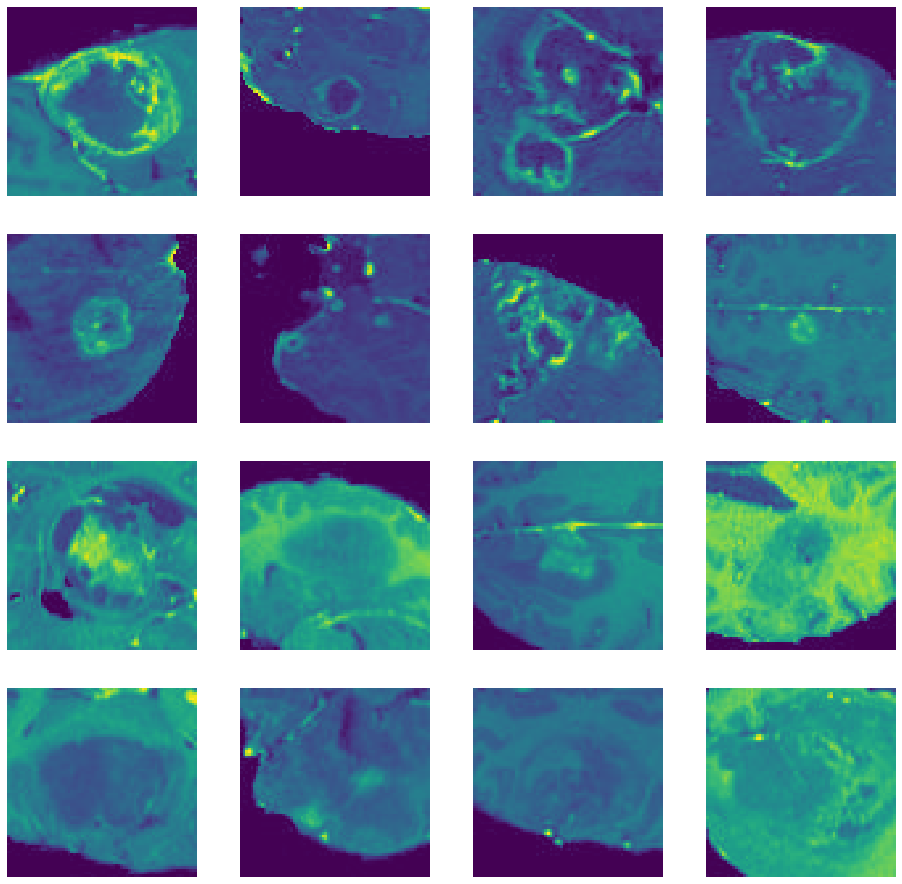

In [ ]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_hgg_pix = [os.path.join(train_hgg_dir, fname) 
                for fname in train_hgg_fnames[pic_index-8:pic_index]]
next_lgg_pix = [os.path.join(train_lgg_dir, fname) 
                for fname in train_lgg_fnames[pic_index-8:pic_index]]

for i, img_path in enumerate(next_hgg_pix+next_lgg_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()


In [ ]:
from tensorflow.keras import layers
from tensorflow.keras import Model

In [ ]:
# Our input feature map is 72 x 72 x 3: 72 x 72 for the image pixels, 3 for
# the three color channels: R, G, and B
img_input = layers.Input(shape=(72, 72, 3))

# First convolution extracts 16 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(16, 3, activation='relu')(img_input)
x = layers.MaxPooling2D(2)(x)

# Second convolution extracts 32 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

# Third convolution extracts 64 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

In [ ]:
# Flatten feature map to a 1-dim tensor so we can add fully connected layers
x = layers.Flatten()(x)

# Create a fully connected layer with ReLU activation and 512 hidden units
x = layers.Dense(512, activation='relu')(x)

# Create output layer with a single node and sigmoid activation
output = layers.Dense(1, activation='sigmoid')(x)

# Create model:
# input = input feature map
# output = input feature map + stacked convolution/maxpooling layers + fully 
# connected layer + sigmoid output layer
model = Model(img_input, output)

In [ ]:
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 72, 72, 3)]       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 70, 70, 16)        448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 35, 35, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 33, 33, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 7, 7, 64)          0   

In [ ]:
from tensorflow.keras.optimizers import RMSprop

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.001),
              metrics=['acc'])

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#Don't need to rescale (data sets already scaled between 0 and 1)
train_datagen = ImageDataGenerator(rescale=1/1)
val_datagen = ImageDataGenerator(rescale=1/1)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=(72, 72),  # All images will be resized to 72 x 72
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# Flow validation images in batches of 5 using val_datagen generator
validation_generator = val_datagen.flow_from_directory(
        validation_dir,
        target_size=(72, 72),
        batch_size=5,
        class_mode='binary')

Found 140 images belonging to 2 classes.
Found 10 images belonging to 2 classes.


In [ ]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=25,  #140 images = batch_size * steps
      epochs=5,
      validation_data=validation_generator,
      validation_steps=5,  #10 images = batch_size * steps
      verbose=2)

Epoch 1/5
Epoch 1/5
25/25 - 1s - loss: 3.7205e-09 - acc: 1.0000 - val_loss: 0.9513 - val_acc: 0.6800
Epoch 2/5
Epoch 1/5
25/25 - 1s - loss: 2.8010e-09 - acc: 1.0000 - val_loss: 1.1375 - val_acc: 0.7200
Epoch 3/5
Epoch 1/5
25/25 - 1s - loss: 1.5293e-09 - acc: 1.0000 - val_loss: 1.2602 - val_acc: 0.6800
Epoch 4/5
Epoch 1/5
25/25 - 1s - loss: 7.9051e-10 - acc: 1.0000 - val_loss: 1.7251 - val_acc: 0.6800
Epoch 5/5
Epoch 1/5
25/25 - 1s - loss: 9.2335e-10 - acc: 1.0000 - val_loss: 1.6068 - val_acc: 0.7200


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in true_divide


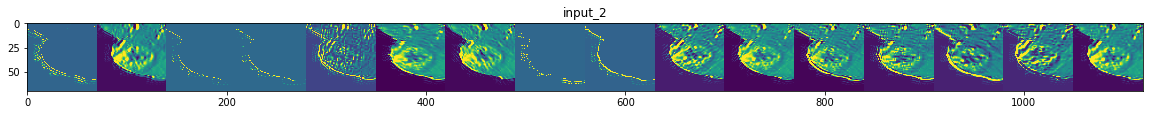

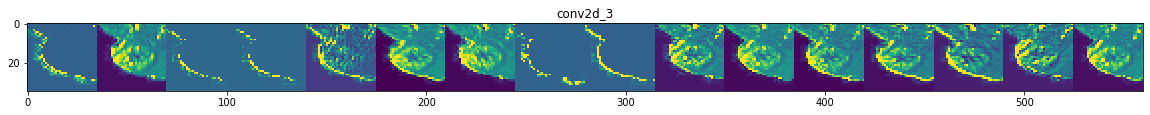

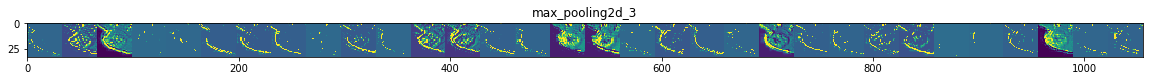

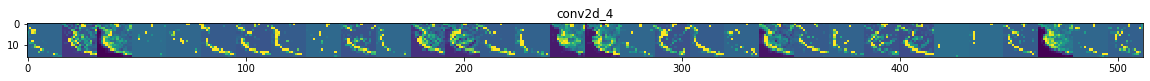

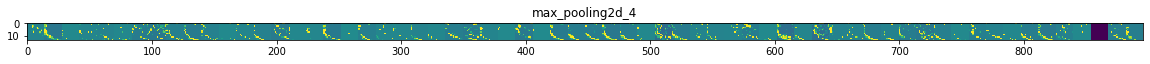

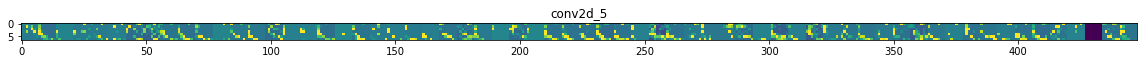

In [ ]:
import numpy as np
import random
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Let's define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after
# the first.
successive_outputs = [layer.output for layer in model.layers[1:]]
visualization_model = Model(img_input, successive_outputs)

# Let's prepare a random input image of a hgg or lgg from the training set.
hgg_img_files = [os.path.join(train_hgg_dir, f) for f in train_hgg_fnames]
lgg_img_files = [os.path.join(train_lgg_dir, f) for f in train_lgg_fnames]
img_path = random.choice(hgg_img_files + lgg_img_files)

img = load_img(img_path, target_size=(72, 72))  # this is a PIL image
x = img_to_array(img)  # Numpy array with shape (72, 72, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 72, 72, 3)

#Don't need to rescale (code below commented out)
#x /= 255 # Rescale by 1/255

# Let's run our image through our network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers]

# Now let's display our representations
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  if len(feature_map.shape) == 4:
    # Do this for the conv/maxpool layers, not the fully-connected layers
    n_features = feature_map.shape[-1]  # number of features in feature map
    # The feature map has shape (1, size, size, n_features)
    size = feature_map.shape[1]
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    for i in range(n_features):
      # Postprocess the feature to make it visually palatable
      x = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std()
      x *= 64
      x += 128
      x = np.clip(x, 0, 255).astype('uint8')
      # We'll tile each filter into this big horizontal grid
      display_grid[:, i * size : (i + 1) * size] = x
    # Display the grid
    scale = 20. / n_features
    plt.figure(figsize=(scale * n_features, scale))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

### Evaluating Accuracy and Loss for the Model

Purpose: plot training/validation accuracy and loss as collected during training.

Text(0.5, 1.0, 'Training and validation loss')

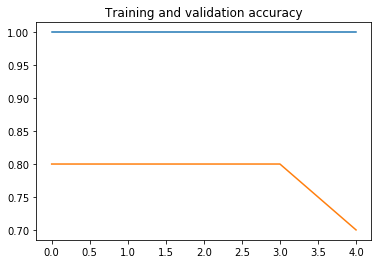

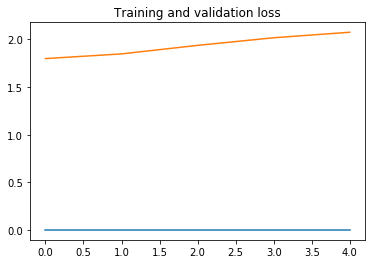

In [ ]:
# Retrieve a list of accuracy results on training and validation data
# sets for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']

# Retrieve a list of list results on training and validation data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch     #blue = training
plt.plot(epochs, acc)                                 #orange = validation
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')

## Clean Up

Before running the next exercise, run the following cell to terminate the kernel and free memory resources:

In [ ]:
import os, signal
os.kill(os.getpid(), signal.SIGKILL)